# Running the DiuSST model and plotting results

Date: 14 Oct 2021

This tutorial provides a complete example of running the DiuSST model using real atmospheric forcing data.

First, we need to load the required standard modules (numpy, matplotlib, pandas) as well as the custom modules containing the code for DiuSST.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Read files in the code folder
import sys
sys.path.append('../code')

# Load custom modules
from diusst_model import diusst
from diusst_interpolation import cfl_interpolation

## Load dataset

Now, we load the dataset (from the MOCE-5 cruise in the Eastern Pacific and Gulf of California) and store it as a pandas DataFrame.

In [2]:
data_path = '../input_data/moce5/'
data_filename = 'training_moce5_err-boatspd-x2_humid10.csv'

data_orig = pd.read_csv(data_path+data_filename)
data_orig

,times,sst,sst_err,ftemp,wind,atemp,swrad,humid,boatspd
0,31625.760,291.797,0.147397,291.538,0.947,290.451,695.5,0.01,12.3
1,32321.472,292.099,0.085068,291.222,1.015,290.947,635.6,0.01,12.4
2,33008.616,292.336,0.147397,291.748,1.167,290.868,559.7,0.01,12.3
3,35765.736,293.311,0.063959,290.777,1.739,291.826,737.2,0.01,1.5
4,36452.880,291.097,0.070329,291.185,2.471,291.596,774.3,0.01,0.5
...,...,...,...,...,...,...,...,...,...
1847,1736233.800,291.047,0.233219,291.618,1.458,291.480,0.5,0.01,8.1
1848,1736879.760,290.679,0.107123,291.191,1.189,291.589,0.5,0.01,8.4
1849,1737525.360,290.740,0.106192,291.205,0.435,291.640,0.6,0.01,8.2
1850,1738171.200,290.996,0.087068,291.312,0.900,291.616,0.6,0.01,8.1


## Specify model settings

In the next cell, we specify all the parameters and other options for the simulation.

In [3]:
# Foundation temperature
T_f = np.mean(data_orig['ftemp'].to_numpy(np.float64))

# Key parameters
param_exp = [7.232567458901045e-05, 0.0038133269783171574, 2.3054145462710807]
param_stab = [8.321236291557062e-05, 0.0040749808773237126, 2.823656517190321]
param_lin2 = [0.00017987473112031528, 0.0025755759192033893, 2.4454753515746566]
lambd = 3
sigma = 0.8

# Options
diffu_type = 'EXP'
wind_max = 10
opac = 1.

# Domain
z_f = 10
dz = 0.1
ngrid = 40

## Interpolate original data

The original dataset has a time intervals of several minutes. If we would input this time series directly into the model, the simulation would become instable because the CFL condition will not be met. Therefore, we must interpolate the dataset such that the time step between adjacent data points is small enough to satisfy the CFL condition. For this purpose, we have written the `cfl_interpolation5` function which we call below. It adapts the time step to the current wind conditions in order to save computation time.

In [4]:
data_intp, dtlist, idx = cfl_interpolation(data_orig,
    dz0=dz, ngrid=ngrid, z_f=z_f,
    kappa=param_exp[0], sigma=sigma, lambd=lambd,
    wind_max=wind_max, CFL_max=0.95, diffu_type='EXP',
    save=None,verbose=True)

+++ Variable time-step interpolation +++
Interpolated dataset has 206852 time steps with average length 8.857 s.
Constant dt interpolation would require dt = 2.679 s --> 637344 steps.
Computation time will be reduced by 67.545 %
++++++++++++++++++++++++++++++++++++++++


In [5]:
data_intp2, dtlist2, idx2 = cfl_interpolation(data_orig,
    dz0=dz, ngrid=ngrid, z_f=z_f,
    kappa=param_stab[0], sigma=sigma, lambd=lambd,
    wind_max=wind_max, CFL_max=0.95, diffu_type='STAB',
    save=None,verbose=True)

+++ Variable time-step interpolation +++
Interpolated dataset has 695472 time steps with average length 4.713 s.
Constant dt interpolation would require dt = 0.573 s --> 2979421 steps.
Computation time will be reduced by 76.657 %
++++++++++++++++++++++++++++++++++++++++


In [7]:
data_intp3, dtlist3, idx3 = cfl_interpolation(data_orig,
    dz0=dz, ngrid=ngrid, z_f=z_f,
    kappa=param_lin2[0], sigma=sigma, lambd=lambd,
    wind_max=wind_max, CFL_max=0.95, diffu_type='LIN2',
    save=None,verbose=True)

+++ Variable time-step interpolation +++
Interpolated dataset has 336477 time steps with average length 6.935 s.
Constant dt interpolation would require dt = 1.274 s --> 1339627 steps.
Computation time will be reduced by 74.883 %
++++++++++++++++++++++++++++++++++++++++


After interpolating the data, we store the individual data variables as separate arrays.

In [8]:
times = data_intp['times'].to_numpy(np.float64)
wind = data_intp['wind'].to_numpy(np.float64)
swave = data_intp['swrad'].to_numpy(np.float64)
airtemp = data_intp['atemp'].to_numpy(np.float64) - data_intp['ftemp'].to_numpy(np.float64) + T_f
humid = data_intp['humid'].to_numpy(np.float64)

times2 = data_intp2['times'].to_numpy(np.float64)
wind2 = data_intp2['wind'].to_numpy(np.float64)
swave2 = data_intp2['swrad'].to_numpy(np.float64)
airtemp2 = data_intp2['atemp'].to_numpy(np.float64) - data_intp2['ftemp'].to_numpy(np.float64) + T_f
humid2 = data_intp2['humid'].to_numpy(np.float64)

times3 = data_intp3['times'].to_numpy(np.float64)
wind3 = data_intp3['wind'].to_numpy(np.float64)
swave3 = data_intp3['swrad'].to_numpy(np.float64)
airtemp3 = data_intp3['atemp'].to_numpy(np.float64) - data_intp3['ftemp'].to_numpy(np.float64) + T_f
humid3 = data_intp3['humid'].to_numpy(np.float64)

In [27]:
times4 = data_intp4['times'].to_numpy(np.float64)
wind4 = data_intp4['wind'].to_numpy(np.float64)
swave4 = data_intp4['swrad'].to_numpy(np.float64)
airtemp4 = data_intp4['atemp'].to_numpy(np.float64) - data_intp4['ftemp'].to_numpy(np.float64) + T_f
humid4 = data_intp4['humid'].to_numpy(np.float64)

## Run the model

We are ready to run the DiuSST model! This works by calling the `diusst` function and specifying all settings above by passing the respective arguments to the function.

In [9]:
start = time.time()

simu = diusst(times, wind, swave, airtemp, humid,
            T_f=T_f, kappa=param_exp[0], mu=param_exp[1], alpha=param_exp[2], lambd=lambd, sigma=sigma,
            diffu_type='EXP', wind_max=wind_max, opac=opac,
            z_f=z_f, dz=dz, ngrid=ngrid, output='basic')

runtime = time.time()-start
print('The simulation took ',round(runtime,2),' seconds.')

The simulation took  11.31  seconds.


In [39]:
start = time.time()

simu2 = diusst(times2, wind2, swave2, airtemp2, humid2,
            T_f=T_f, kappa=param_stab[0], mu=param_stab[1], alpha=param_stab[2], lambd=lambd, sigma=sigma,
            diffu_type='STAB', wind_max=wind_max, opac=opac,
            z_f=z_f, dz=dz, ngrid=ngrid, output='basic')

runtime = time.time()-start
print('The simulation took ',round(runtime,2),' seconds.')

The simulation took  19.61  seconds.


In [37]:
start = time.time()

simu3 = diusst(times3, wind3, swave3, airtemp3, humid3,
            T_f=T_f, kappa=param_lin2[0], mu=param_lin2[1], alpha=param_lin2[2], lambd=lambd, sigma=0.9,
            diffu_type='LIN2', wind_max=wind_max, opac=opac,
            z_f=z_f, dz=dz, ngrid=ngrid, output='basic')

runtime = time.time()-start
print('The simulation took ',round(runtime,2),' seconds.')

The simulation took  10.81  seconds.


In [28]:
start = time.time()

simu4 = diusst(times4, wind4, swave4, airtemp4, humid4,
            T_f=T_f, kappa=kappa, mu=mu, alpha=alpha, lambd=2, sigma=sigma,
            diffu_type='STAB', wind_max=wind_max, opac=opac,
            z_f=z_f, dz=dz, ngrid=ngrid, output='basic')

runtime = time.time()-start
print('The simulation took ',round(runtime,2),' seconds.')

The simulation took  45.51  seconds.


The dataset provides the temperature difference between the sea skin (SST) and the water temperature at 3m depth (ftemp). Therefore, to compare our simulation with the observational data, we must find the grid point closest to 3m depth and take the temperature difference with respect to that grid point.

In [41]:
ref_level = int(20)
simu_sst = simu[0][:,0]-simu[0][:,ref_level]
simu2_sst = simu2[0][:,0]-simu2[0][:,ref_level]
simu3_sst = simu3[0][:,0]-simu3[0][:,ref_level]
#simu4_sst = simu4[0][:,0]-simu4[0][:,ref_level]

print('Reference depth (in m) at which the SST difference is taken: ',round(simu[1][ref_level],2))

Reference depth (in m) at which the SST difference is taken:  -3.05


## Plot results

Finally, let us plot the results of our simulation.

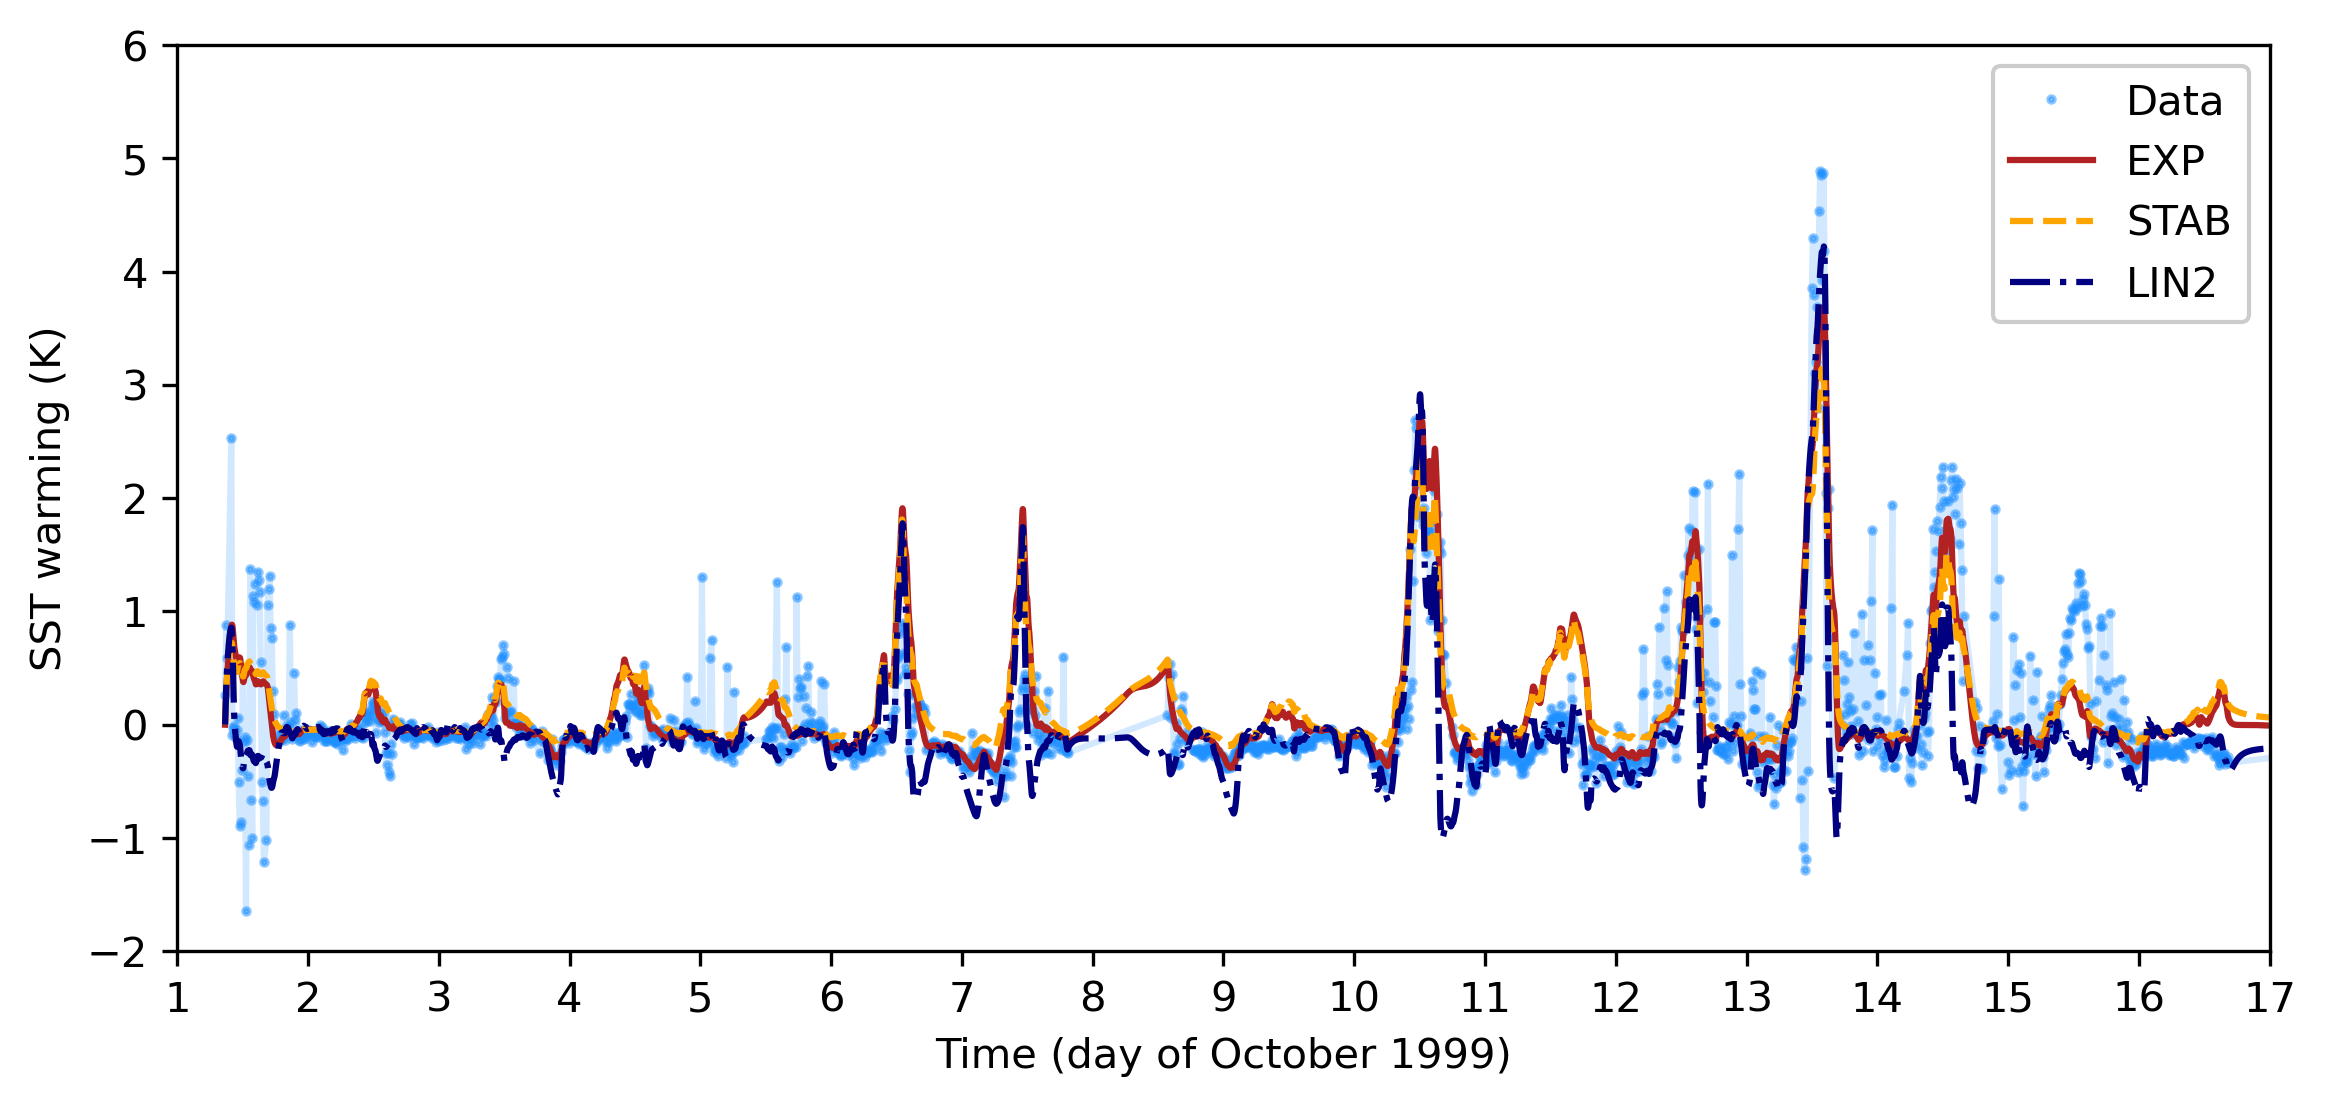

In [42]:
fig, ax = plt.subplots(dpi=300,figsize=(9,4))

ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'],alpha=0.2,c='dodgerblue')
ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'],'.',markersize=3,alpha=0.5,c='dodgerblue', label='Data')

ax.plot(simu[2]/86400,simu_sst,c='firebrick', label='EXP')
ax.plot(simu2[2]/86400,simu2_sst,'--',c='orange', label='STAB')
ax.plot(simu3[2]/86400,simu3_sst,'-.',c='navy', label='LIN2')
#ax.plot(simu4[2]/86400,simu4_sst,'-.',c='navy', label='STAB2')

ax.legend(framealpha=1)
ax.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
ax.set_ylim(-2,6)
#ax.set_xlim(0,16)
ax.set_xlim(0,16)
ax.set(xlabel='Time (day of October 1999)')
ax.set(ylabel='SST warming (K)')

plt.show()

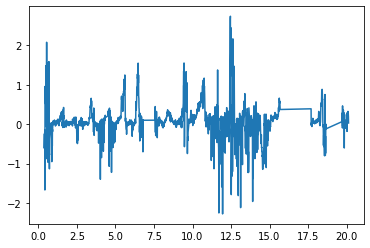

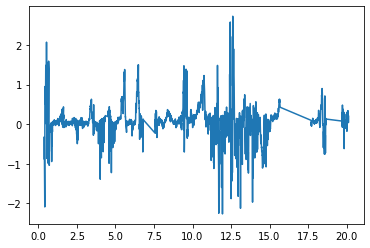

In [28]:
#plt.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'],alpha=0.9,c='red')
plt.plot(data_orig['times'][1:]/86400,simu_sst[idx]-data_orig['sst'][:-1]+data_orig['ftemp'][:-1])
plt.show()
plt.plot(data_orig['times'][1:]/86400,simu_sst[idx]-data_orig['sst'][1:]+data_orig['ftemp'][1:])


In [34]:
error = np.sum((simu_sst[idx]-(data_orig['sst'][1:]-data_orig['ftemp'][1:]))**2)
error2 = np.sum((simu2_sst[idx]-(data_orig['sst'][1:]-data_orig['ftemp'][1:]))**2)
error3 = np.sum((simu3_sst[idx]-(data_orig['sst'][1:]-data_orig['ftemp'][1:]))**2)

In [35]:
print(error)
print(error2)
print(error3)

344.3715139734287
712.0162011856702
790.0455360653399
